In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from sklearn.preprocessing import MinMaxScaler
#from scipy.stats import boxcox
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
import sklearn
from sklearn import metrics
import math

2023-04-30 18:39:06.933504: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Model 1

In [2]:
start = dt.datetime(2009, 1, 1)
end = dt.datetime(2021, 1, 1)

data = pdr.get_data_yahoo('^DJI', start, end)
data = data.reset_index()
data = data.dropna()
#data1 = data.copy()

[*********************100%***********************]  1 of 1 completed


In [3]:
train_data = data[data['Date']<"2018-01-01"]
test_data = data[data['Date']>="2018-01-01"]

In [4]:
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(train_data['Close'].values.reshape(-1,1))

In [5]:
window_size = 3

x_train=[]
y_train=[]

for x in range(window_size, len(scaled_data)):
    x_train.append(scaled_data[x-window_size:x, 0])
    y_train.append(scaled_data[x, 0])

In [6]:
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [7]:
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1)) #prediction of the next closing value

model.compile(optimizer='adam', loss='mean_squared_error')
es = EarlyStopping(monitor='loss', min_delta=1e-10, patience=10, verbose=1)
history = model.fit(x_train, y_train, epochs=5, batch_size=32,callbacks=[es])

2023-04-30 18:39:13.853285: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/5
71/71 [==============================] - 7s 8ms/step - loss: 0.0559
Epoch 2/5
71/71 [==============================] - 1s 10ms/step - loss: 0.0038
Epoch 3/5
71/71 [==============================] - 1s 11ms/step - loss: 0.0030
Epoch 4/5
71/71 [==============================] - 1s 8ms/step - loss: 0.0025
Epoch 5/5
71/71 [==============================] - 1s 8ms/step - loss: 0.0023


In [8]:
actual_prices=test_data['Close'].values

total_dataset=pd.concat((train_data['Close'], test_data['Close']), axis=0)

model_inputs=total_dataset[len(total_dataset)-len(test_data)-window_size:].values
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scaler.transform(model_inputs)

In [9]:
x_test=[]

for x in range(window_size, len(model_inputs)):
    x_test.append(model_inputs[x-window_size:x, 0])

x_test=np.array(x_test)
x_test=np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predicted_prices=model.predict(x_test)
predicted_prices=scaler.inverse_transform(predicted_prices)

24/24 [==============================] - 1s 5ms/step


In [10]:
predicted_prices1 = predicted_prices.copy()
predicted_prices = predicted_prices[5:]

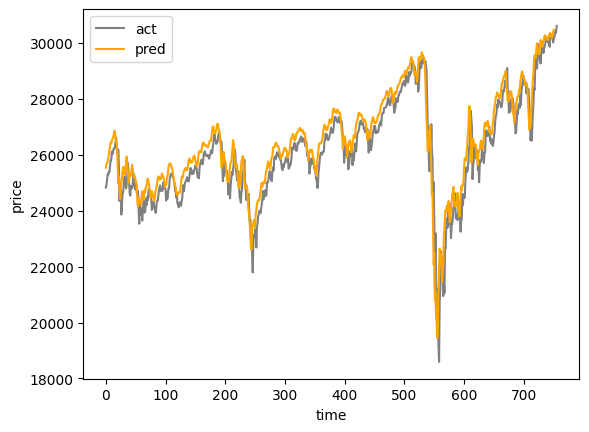

In [11]:
#Plot test predction
plt.plot(test_data.reset_index()['Close'], color = 'grey', label = 'act')
plt.plot(predicted_prices, color = 'orange', label = 'pred')

plt.xlabel('time')
plt.ylabel('price')
plt.legend()
plt.show()

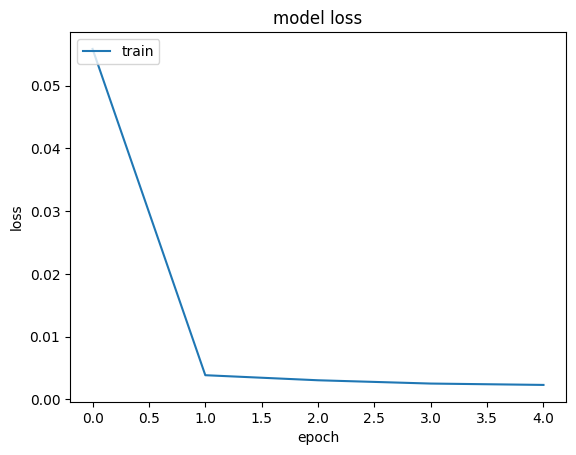

In [12]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [13]:
math.sqrt(metrics.mean_squared_error(actual_prices[5:],predicted_prices))

600.9313197144119

In [14]:
metrics.mean_absolute_error(actual_prices[5:],predicted_prices)

424.59346132240347

## Model 2

In [15]:
data2 = test_data.copy()

In [18]:
data2['SMA'] = data2['Close'].rolling(window_size).mean()

In [19]:
data2 = data2.reset_index()

In [20]:
df = pd.DataFrame({'act1':actual_prices.ravel(), 'pred1':predicted_prices1.ravel()})

In [21]:
data2 = pd.merge(data2, df, left_on ='Close', right_on ='act1',how='left')

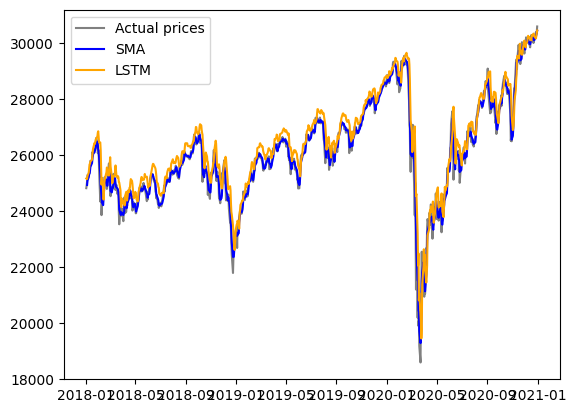

In [22]:
plt.plot(data2['Date'], data2['act1'], label = 'Actual prices', color = 'grey')
plt.plot(data2['Date'], data2['SMA'], label = 'SMA', color = 'blue')
plt.plot(data2['Date'], data2['pred1'], label = 'LSTM', color = 'orange')
plt.legend()

In [23]:
math.sqrt(metrics.mean_squared_error(data2['act1'][window_size-1:].dropna(), data2['SMA'].dropna()))

255.3967430655391

In [24]:
metrics.mean_absolute_error(data2['act1'][window_size-1:].dropna(), data2['SMA'].dropna())

166.29108365713176

## Differenced data for Model 1

In [25]:
data1 = data.copy()
data1['Close'][1:] = np.diff(data1['Close'])

/Users/danamalas/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [26]:
train_data1 = data1[data1['Date']<="2018-01-01"]
test_data1 = data1[data1['Date']>"2018-01-01"]

In [27]:
#train_data1['Close'] = train_data1['Close'].diff(periods=1).dropna()
#train_data1['Close'] = train_data1['Close']/10
#train_data1 = train_data1.dropna()
#train_data1['Close'] = train_data1['Close'].dropna()

In [28]:
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(train_data1['Close'].values.reshape(-1,1))

In [29]:
#df = pd.DataFrame(scaled_data, columns = ['Close'])

In [30]:
#df['Close'] = df['Close'].diff(periods=1).dropna()

In [31]:
#df = df.dropna()
#scaled_data = train_data1['Close'].values.reshape(-1,1)

In [32]:
window_size = 3

x_train=[]
y_train=[]

for x in range(window_size, len(scaled_data)):
    x_train.append(scaled_data[x-window_size:x, 0])
    y_train.append(scaled_data[x, 0])

In [33]:
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [34]:
%%capture
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1)) #prediction of the next closing value

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=10, batch_size=32)

In [35]:
#Load Test Data
#test_start=dt.datetime(2021, 1, 1)
#test_end=dt.datetime.now()

#test_data = pdr.get_data_yahoo('^DJI', test_start, test_end)
actual_prices=test_data1['Close'].values

total_dataset=pd.concat((train_data1['Close'], test_data1['Close']), axis=0)

model_inputs=total_dataset[len(total_dataset)-len(test_data)-window_size:].values
model_inputs = model_inputs.reshape(-1, 1)
#model_inputs = scaler.transform(model_inputs)

In [36]:
x_test=[]

for x in range(window_size, len(model_inputs)):
    x_test.append(model_inputs[x-window_size:x, 0])

x_test=np.array(x_test)
x_test=np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predicted_prices=model.predict(x_test)
#predicted_prices = rebuild_diffed(predicted_prices, 24824.009766).reshape(-1, 1)
#predicted_prices=scaler.inverse_transform(predicted_prices)

24/24 [==============================] - 1s 3ms/step


In [37]:
predicted_prices1 = predicted_prices.copy()
predicted_prices = predicted_prices[5:]

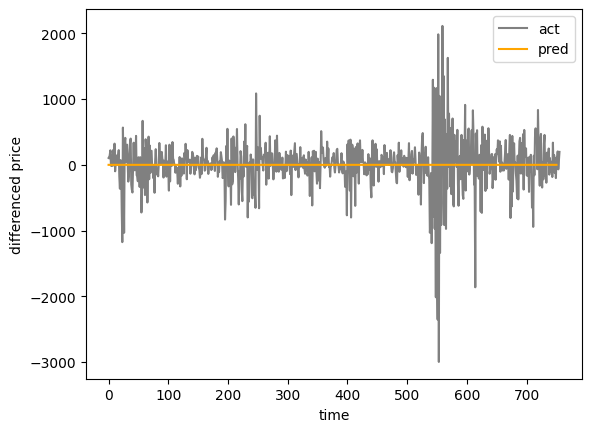

In [53]:
#Plot test predction
plt.plot(test_data1.reset_index()['Close'], color = 'gray', label = 'act')
plt.plot(predicted_prices, color = 'orange', label = 'pred')

plt.xlabel('time')
plt.ylabel('differenced price')
plt.legend()
plt.show()

In [39]:
########################################################################

# Data analysis

(array([ 10.,  18.,  62.,  47.,  37.,  79., 149., 112.,  94., 152., 173.,
         87.,  31.,  61., 100.,  87., 156., 126., 232., 161.,  22.,   8.,
         43.,  66.,  49.,  43.,  24.,  25.,  58.,  79., 103., 108., 114.,
         96.,  51.,  52.,  41.,  30.,  17.,  18.]),
 array([ 6547.04980469,  7148.53557129,  7750.02133789,  8351.50710449,
         8952.99287109,  9554.4786377 , 10155.9644043 , 10757.4501709 ,
        11358.9359375 , 11960.4217041 , 12561.9074707 , 13163.3932373 ,
        13764.87900391, 14366.36477051, 14967.85053711, 15569.33630371,
        16170.82207031, 16772.30783691, 17373.79360352, 17975.27937012,
        18576.76513672, 19178.25090332, 19779.73666992, 20381.22243652,
        20982.70820313, 21584.19396973, 22185.67973633, 22787.16550293,
        23388.65126953, 23990.13703613, 24591.62280273, 25193.10856934,
        25794.59433594, 26396.08010254, 26997.56586914, 27599.05163574,
        28200.53740234, 28802.02316895, 29403.50893555, 30004.99470215,
      

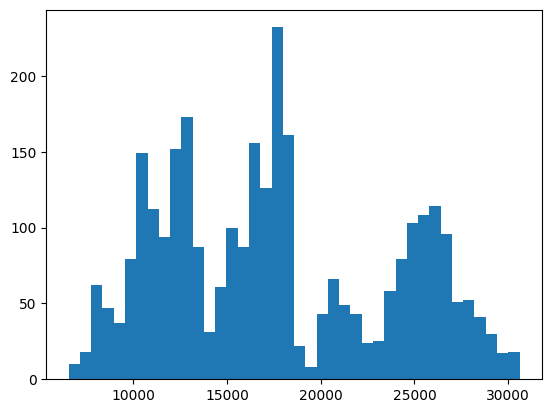

In [40]:
plt.hist(data['Close'],bins = 40)

(array([  8.,  12.,  17.,  55.,  41.,  21.,  36.,  73., 121.,  86.,  90.,
         62., 122., 125., 118.,  37.,  26.,  39.,  60.,  78.,  65., 138.,
         92.,  93., 203., 128.,  38.,  13.,   9.,  35.,  30.,  49.,  33.,
         34.,  15.,  12.,  19.,  10.,   8.,  14.]),
 array([ 6547.04980469,  7004.31130371,  7461.57280273,  7918.83430176,
         8376.09580078,  8833.3572998 ,  9290.61879883,  9747.88029785,
        10205.14179687, 10662.4032959 , 11119.66479492, 11576.92629395,
        12034.18779297, 12491.44929199, 12948.71079102, 13405.97229004,
        13863.23378906, 14320.49528809, 14777.75678711, 15235.01828613,
        15692.27978516, 16149.54128418, 16606.8027832 , 17064.06428223,
        17521.32578125, 17978.58728027, 18435.8487793 , 18893.11027832,
        19350.37177734, 19807.63327637, 20264.89477539, 20722.15627441,
        21179.41777344, 21636.67927246, 22093.94077148, 22551.20227051,
        23008.46376953, 23465.72526855, 23922.98676758, 24380.2482666 ,
      

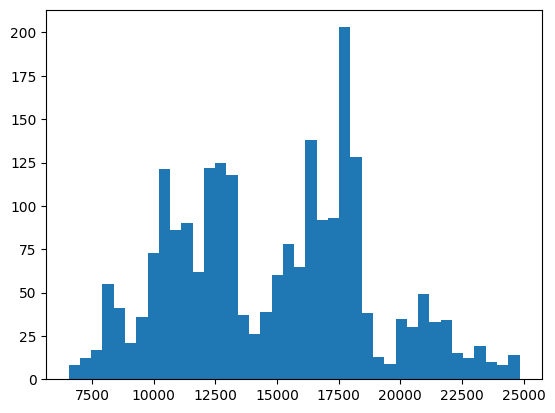

In [41]:
plt.hist(train_data['Close'],bins = 40)

(array([ 1.,  1.,  0.,  0.,  2.,  1.,  0.,  2.,  4.,  1.,  2.,  1.,  2.,
         4.,  4.,  7., 16., 21., 27., 42., 47., 45., 55., 53., 66., 47.,
        53., 44., 32., 18., 29., 23., 23., 18., 14., 16.,  8.,  9., 14.,
         4.]),
 array([18591.9296875 , 18892.29345703, 19192.65722656, 19493.02099609,
        19793.38476562, 20093.74853516, 20394.11230469, 20694.47607422,
        20994.83984375, 21295.20361328, 21595.56738281, 21895.93115234,
        22196.29492188, 22496.65869141, 22797.02246094, 23097.38623047,
        23397.75      , 23698.11376953, 23998.47753906, 24298.84130859,
        24599.20507812, 24899.56884766, 25199.93261719, 25500.29638672,
        25800.66015625, 26101.02392578, 26401.38769531, 26701.75146484,
        27002.11523438, 27302.47900391, 27602.84277344, 27903.20654297,
        28203.5703125 , 28503.93408203, 28804.29785156, 29104.66162109,
        29405.02539062, 29705.38916016, 30005.75292969, 30306.11669922,
        30606.48046875]),
 <BarContainer objec

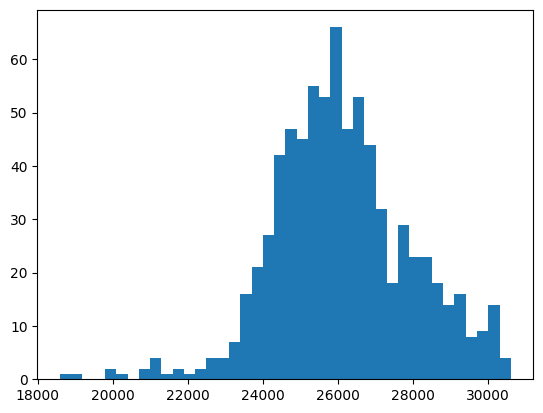

In [42]:
plt.hist(test_data['Close'],bins = 40)

In [43]:
adfuller(data['Close'])

(-0.2374306644271012,
 0.933910414810336,
 27,
 2993,
 {'1%': -3.432536741492438,
  '5%': -2.862506160743024,
  '10%': -2.5672843129045173},
 40354.406843980214)

In [44]:
adfuller(train_data['Close'])

(0.7775683223479853,
 0.9912653130447012,
 5,
 2259,
 {'1%': -3.433248072725654,
  '5%': -2.8628202931061955,
  '10%': -2.567451559747925},
 27858.556193600827)

In [45]:
adfuller(test_data['Close'])

(-2.4347580246079366,
 0.13216551805070903,
 9,
 746,
 {'1%': -3.439146171679794,
  '5%': -2.865422101274577,
  '10%': -2.568837245865348},
 10713.676404706486)

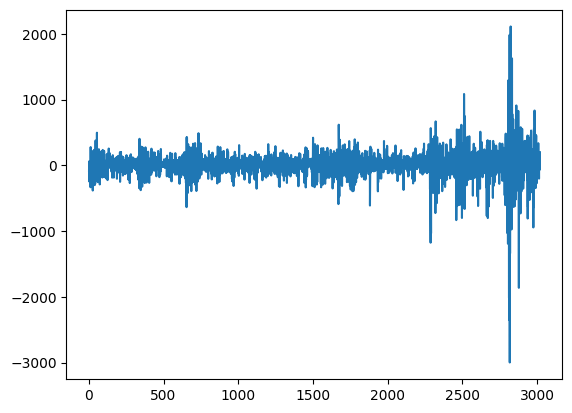

In [46]:

plt.plot(data['Close'].diff(periods=1).dropna())

In [47]:
adfuller(data['Close'].dropna().diff(periods=1).dropna()) 

(-11.336769226111153,
 1.0788949870548927e-20,
 26,
 2993,
 {'1%': -3.432536741492438,
  '5%': -2.862506160743024,
  '10%': -2.5672843129045173},
 40337.32991933587)

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 2.000e+00,
        0.000e+00, 4.000e+00, 4.000e+00, 6.000e+00, 7.000e+00, 1.700e+01,
        1.700e+01, 3.900e+01, 9.600e+01, 2.030e+02, 5.690e+02, 1.144e+03,
        5.380e+02, 2.210e+02, 7.400e+01, 3.500e+01, 1.800e+01, 4.000e+00,
        4.000e+00, 2.000e+00, 1.000e+00, 2.000e+00, 2.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00]),
 array([-2997.09960938, -2894.89800781, -2792.69640625, -2690.49480469,
        -2588.29320313, -2486.09160156, -2383.89      , -2281.68839844,
        -2179.48679687, -2077.28519531, -1975.08359375, -1872.88199219,
        -1770.68039062, -1668.47878906, -1566.2771875 , -1464.07558594,
        -1361.87398437, -1259.67238281, -1157.47078125, -1055.26917969,
         -953.06

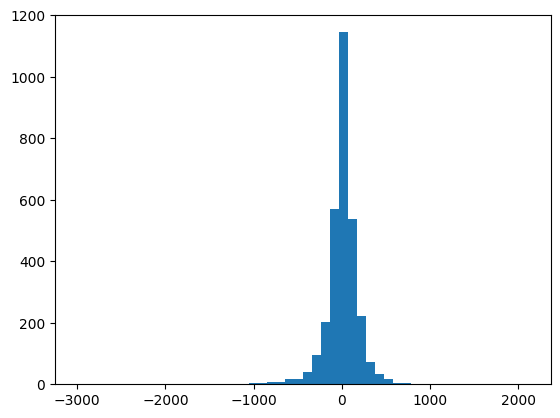

In [51]:
adfuller(scaled_data)
plt.hist(data['Close'].diff(periods=1).dropna(),bins = 50)

In [ ]:
#perform augmented Dickey-Fuller test
adfuller(data)

(-0.9753836234744063,
 0.7621363564361013,
 0,
 12,
 {'1%': -4.137829282407408,
  '5%': -3.1549724074074077,
  '10%': -2.7144769444444443},
 31.2466098872313)
Here’s how to interpret the most important values in the output:

Test statistic: -0.97538
P-value: 0.7621
Since the p-value is not less than .05, we fail to reject the null hypothesis.

This means the time series is non-stationary. In other words, it has some time-dependent structure and does not have constant variance over time.


## För att få bort non-stationarity kan vi differentiera
#df["series"].diff(periods=1)

